In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *
from scripts.mane_utils import *

In [2]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
cerb_t_metadata = '../'+expand(config['data']['t_info'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]

In [4]:
def get_mp_orf_table(sg,
                    ca,
                    pp_summary,
                    ref_t_metadata,
                    ref_g_metadata,
                    obs_col,
                    min_feat_tpm):

    mp_df = get_mp_df_table(sg, ca, 
                           ref_t_metadata,
                           ref_g_metadata,
                           obs_col,
                           min_feat_tpm,
                           feat='triplet')

    pp_df = pd.read_csv(pp_summary, sep='\t')

    temp = mp_df.merge(pp_df[['tid', 'seq', 'len', 'nmd', 'full_orf']],
                        how='left',
                        left_on='tid_princ',
                        right_on='tid',
                        suffixes=('', '_orf_princ'))
    temp = temp.merge(pp_df[['tid', 'seq', 'len', 'nmd', 'full_orf']],
                        how='left',
                        left_on='tid_mane',
                        right_on='tid',
                        suffixes=('', '_orf_mane'))

    return temp

In [5]:
def plot_browser_isos(ca, sg, gene, obs_col, obs_condition, filt_ab, pp_summary, major_set,
                       ref_t_metadata, ref_g_metadata,
                               h=0.1, w=56, x=14, fig_w=14, ref_sources=['v29','v40'], species='human',
                               h_space=None,
                               add_tss=False, add_ccre=False, major=False, order='expression',
                     light_shade=None, dark_shade=None):
    """
    Plot browser style isoform models for a given sample
    """

    def plot_tss(ca, sg, tpm_df, x, y, h, ax):
        tpm_df = add_feat(tpm_df, kind='tss', col='transcript_id')
        tpm_df.head()
        tss_df = ca.tss.loc[ca.tss.Name.isin(tpm_df.tss.tolist())]
        tss_df.head()
        regions = [(entry.Start, entry.End) for ind, entry in tss_df.iterrows()]
        color = get_sector_colors()[0]['tss']
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
        return ax

    def plot_ccre(ca, sg, x, y, h, ax):

        # ccre regions
        sources = ['pls', 'pels', 'dels']
        ccre = ca.tss_map.loc[ca.tss_map.source.isin(sources)].copy(deep=True)

        # get ranges w/i this region
        min_coord = sg.pg.g_min
        max_coord = sg.pg.g_max
        chrom = sg.pg.chrom

        ccre['min_coord'] = ccre[['Start', 'End']].min(axis=1)
        ccre['max_coord'] = ccre[['Start', 'End']].max(axis=1)

        # subset on regions
        ccre = pr.PyRanges(ccre)
        region = pr.from_dict({'Chromosome': [chrom],
                                        'Start': [min_coord],
                                        'End': [max_coord]})
        # ccre = ccre.intersect(region, strandedness=None, how='containment')
        ccre = ccre.intersect(region, strandedness=None)
        ccre = ccre.as_df()

        # colors
        c_dict, _ = get_ccre_colors()
        colors = [c_dict[s] for s in ccre.source.tolist()]
        regions = [(entry.Start, entry.End) for ind, entry in ccre.iterrows()]
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, colors, ax)

        return ax

    def get_major_isos(major_set, gene, sample=None):
        """
        Get list of major isfoorms in a given sample
        """
        df = pd.read_csv(major_set, sep='\t')
        df = df.loc[df.gname == gene]
        if sample:
            df = df.loc[df['sample'] == sample]
        tids = df.tid.unique().tolist()
        return tids

    def get_isos(ca, filt_ab, gene, sample, species):
        df = pd.read_csv(filt_ab, sep='\t')
        df = get_det_table(df,
                       groupby='sample',
                       how='iso',
                       min_tpm=1,
                       gene_subset='polya',
                       species=species)
        df = df.loc[sample]
        df = df.to_frame()
        df = df.loc[df[sample]==True]
        gid = ca.triplets.loc[ca.triplets.gname==gene, 'gid'].values[0]
        df.reset_index(inplace=True)
        df['gid'] = df['index'].str.split('[', expand=True)[0]
        df = df.loc[df.gid == gid]
        tids = df['index'].tolist()
        return tids


    def get_tpm_df(sg, tids, obs_col, obs_condition):
        # get tpm df
        tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
        tpm_df = tpm_df.transpose()
        tpm_df = tpm_df.loc[tids, obs_condition].to_frame()
        return tpm_df

    if major:
        tids = get_major_isos(major_set, gene, obs_condition)
    else:
        tids = get_isos(ca, filt_ab, gene, obs_condition, species)
    tpm_df = get_tpm_df(sg, tids, obs_col, obs_condition)

    # colormap definition
    # if cmap == 'gray':
    if not light_shade:
        light_shade = get_sector_colors()[0]['mixed']
    if not dark_shade:
        dark_shade = get_sector_colors()[0]['simple']
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', [light_shade, dark_shade])
    # else:
    #     pass


    # font sizes
    # small_text = 6/(6.11/16)
    small_text = 20.3
    big_text = 6.71/(6.11/16)
    # print('small text size: {}'.format(small_text))
    # print('big text size: {}'.format(big_text))


    # height spacing b/w models
    if not h_space:
        h_space = h*1.75
    # print('h_space : {}'.format(h_space))
    # print('h: {}'.format(h))

    # plotting settings
    fig_len = len(tids)
    fig_len += 1 # for scale
    if add_tss:
        fig_len += 1
    if add_ccre:
        fig_len += 1
    fig_h = h_space*(fig_len-1)+h
    fig_h += 0.3 # vertical spacing adjustment
    # print('fig h: {}'.format(fig_h))
    # print('fig w: {}'.format(fig_w))
    plt.figure(1, figsize=(fig_w, fig_h), frameon=False)
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    ax = plt.gca()

    # plotting order
    tpm_df = tpm_df.sort_values(by=obs_condition, ascending=False)
    tpm_df = tpm_df[[obs_condition]]

    if order == 'tss':
        tpm_df = add_feat(tpm_df, kind='tss', col='index')
        tpm_df.sort_values(by=['tss', obs_condition], ascending=[True, False], inplace=True)
        tpm_df.drop('tss', axis=1, inplace=True)

    # x coords for gencode name and cerberus name
    x_gc = -4
    x_mo = 10
    x_c = 12

    # add reference ids
    if species == 'human':
        ref_source = 'v40'
    elif species == 'mouse':
        ref_source = 'vM25'
    df = ca.t_map.loc[ca.t_map.source == ref_source]
    df = df[['transcript_id','original_transcript_id', 'original_transcript_name']]
    tpm_df = tpm_df.merge(df, how='left', left_index=True, right_on='transcript_id')

    # clean up for transcripts that aren't known
    df = ca.t_map.loc[ca.t_map.source == 'lapa']
    df = df[['gene_name', 'transcript_id', 'transcript_name',
             'tss_id', 'ic_id', 'tes_id']].drop_duplicates()
    tpm_df = tpm_df.merge(df, how='left', on='transcript_id')
    tpm_df.fillna('N/A', inplace=True)

    # label known transcripts with a *
    tpm_df['Known'] = ''
    tpm_df = tpm_df.copy(deep=True)
    tpm_df = tpm_df.merge(ca.ic[['Name', 'novelty']], how='left', left_on='ic_id', right_on='Name')
    tpm_df.rename({'novelty':'ic_novelty'}, axis=1, inplace=True)
    tpm_df.drop('Name', axis=1, inplace=True)
    tpm_df = tpm_df.merge(ca.tss[['Name', 'novelty']], how='left', left_on='tss_id', right_on='Name')
    tpm_df.rename({'novelty':'tss_novelty'}, axis=1, inplace=True)
    tpm_df.drop('Name', axis=1, inplace=True)
    tpm_df = tpm_df.merge(ca.tes[['Name', 'novelty']], how='left', left_on='tes_id', right_on='Name')
    tpm_df.rename({'novelty':'tes_novelty'}, axis=1, inplace=True)
    tpm_df.drop('Name', axis=1, inplace=True)
    # tpm_df.loc[(tpm_df.tss_novelty=='Known')&\
    #            (tpm_df.ic_novelty=='Known')&\
    #            (tpm_df.tes_novelty=='Known'), 'Known'] = '*'
    if species == 'human':
        refs = ['v40', 'v29']
    elif species == 'mouse':
        refs = ['vM21', 'vM25']
    known_tids = ca.t_map.loc[ca.t_map.source.isin(refs)].transcript_id.unique().tolist()
    tpm_df.loc[tpm_df.transcript_id.isin(known_tids), 'Known'] = '*'

    # triplets rather than entire transcript name
    tpm_df['triplet'] = tpm_df.transcript_id.str.split('[', n=1, expand=True)[1]
    tpm_df['triplet'] = tpm_df.triplet.str.split(']', n=1, expand=True)[0]
    tpm_df['triplet'] = '['+tpm_df.triplet+']'
    
    # orf status stuff
    pp_df = pd.read_csv(pp_summary, sep='\t')
    pp_df.rename({'tid': 'transcript_id'}, axis=1, inplace=True)
    
    tpm_df = tpm_df.merge(pp_df[['transcript_id', 'nmd', 'full_orf', 'seq']], 
                          how='left', 
                          on='transcript_id')
    tpm_df['protein'] = ''
    tpm_df.loc[(tpm_df.nmd==False)&(tpm_df.full_orf==True), 'protein'] = '*' # transcripts w/ predicted protein coding potential
    
    # are these the mane orf
    if species == 'human':
        tpm_df['gid'] = tpm_df['ic_id'].str.split('_', expand=True)[0]
        gid = tpm_df.gid.values[0]
        mane_orf = get_mane_orf(pp_summary,
                                'v40_cerberus',
                                gid=gid).seq.values[0]
        tpm_df['is_mane_orf'] = tpm_df['seq'] == mane_orf
        pdb.set_trace()
        
        tpm_df['mane_orf'] = ''
        tpm_df.loc[tpm_df.seq==mane_orf, 'mane_orf'] = '*'
        
    i = 0
    # print('h: {}'.format(h))
    for index, entry in tpm_df.iterrows():

        # y coords
        y = (len(tpm_df.index) - i)*(h_space)
        y_text = y+(h/2)

        # tid
        tid = entry['transcript_id']
        gname = entry['gene_name']
        tname = entry['transcript_name']
        ref_tname = entry['original_transcript_name']
        trip = entry['triplet']
        iso_trip = '{} {}'.format(gname, trip)
        known = entry['Known']
        pc = entry['protein']
        if species=='human':
            mo = entry['mane_orf']

        # color by TPM
        if len(tpm_df.index) == 1:
            norm_val = entry[obs_condition]
        else:
            norm_val = (entry[obs_condition]-tpm_df[obs_condition].min())/(tpm_df[obs_condition].max()-tpm_df[obs_condition].min())
        color = cmap(norm_val)
        ax = sg.plot_browser(tid, y=y, x=x, h=h, w=w, color=color, ax=ax)
        # print('transcipt #{}, {}, y = {}'.format(i, iso_trip, y))

        # isoform name / novelty
        ax.text(x_c, y_text, known,
                verticalalignment='center',
                horizontalalignment='center',
                size=small_text)
        
        if pc == '*':
            ax.text(x_gc, y_text, iso_trip,
                    verticalalignment='center',
                    horizontalalignment='left',
                    size=small_text, weight='bold')
        else:
            ax.text(x_gc, y_text, iso_trip,
                    verticalalignment='center',
                    horizontalalignment='left',
                    size=small_text)
        if species=='human':
            ax.text(x_mo, y_text, pc,
                    verticalalignment='center',
                    horizontalalignment='left',
                    size=small_text)

        i += 1

    # label the different columns
    # y = (len(tpm_df.index)+1)*(h_space)
   # # ax.text(x_c, y+(h/2), 'Cerberus Name',
    ##     verticalalignment='center',
    ##     horizontalalignment='center')
    ## ax.text(x_gc,y+(h/2), 'GENCODE v40 Name',
    ##         verticalalignment='center',
          #  # horizontalalignment='center')

    # ax.text(x_c, y+(h/2), 'Known',
    #     verticalalignment='center',
    #     horizontalalignment='center',
    #     size=big_text)
    # ax.text(x_gc,y+(h/2), 'Isoform triplet',
    #         verticalalignment='center',
    #         horizontalalignment='center',
    #         size=big_text)


    i = len(tpm_df.index)
    if add_tss:
        y = (len(tpm_df.index) - i)*(h_space)
        ax = plot_tss(ca, sg, tpm_df, x, y, h, ax)
        i += 1

    if add_ccre:
        y = (len(tpm_df.index) - i)*(h_space)
        ax = plot_ccre(ca, sg, x, y, h, ax)
        i += 1

    # add scale
    y = (len(tpm_df.index) - i)*(h_space)
    # print('y scale: {}'.format(y))
    ax = sg.pg.plot_scale(x, y, h, 14, ax)

    # remove axes
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()

    # set x / y lim
    y_max = (len(tpm_df.index) - 0)*(h_space)+h
    y_min = y
    plt.ylim((y_min,y_max))
    plt.xlim((-4, 72))
    # print('ylim: ({},{})'.format(y_min,y_max))

    return ax, tpm_df

def plot_browser_isos_2(h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        ref_t_metadata,
                        ref_g_metadata,
                        gene,
                        obs_col,
                        obs_condition,
                        ofile,
                        h=0.2,
                        ref_sources=['v29', 'v40'],
                        **kwargs):

    ca = cerberus.read(h5)
    sg = swan.read(swan_file)

    ax, tpm_df = plot_browser_isos(ca,
                                   sg,
                                   gene,
                                   obs_col,
                                   obs_condition,
                                   filt_ab,
                                   pp_summary,
                                   major_isos,
                                   ref_t_metadata,
                                   ref_g_metadata,
                                   h=h,
                                   ref_sources=ref_sources,
                                   **kwargs)
    plt.savefig(ofile, dpi=500)


Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2069: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2068: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
> <ipython-input-5-cf2466ee1d69>(213)plot_browser_isos()
    211         pdb.set_trace()
    212 
--> 213         tpm_df['mane_orf'] = ''
    214         tpm_df.loc[tpm_df.seq==mane_orf, 'mane_orf'] = '*'
    215 



ipdb>  n


> <ipython-input-5-cf2466ee1d69>(214)plot_browser_isos()
    212 
    213         tpm_df['mane_orf'] = ''
--> 214         tpm_df.loc[tpm_df.seq==mane_orf, 'mane_orf'] = '*'
    215 
    216     i = 0



ipdb>  mane_orf


'MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTGIICTIGPASRSVETLKEMIKSGMNVARLNFSHGTHEYHAETIKNVRTATESFASDPILYRPVAVALDTKGPEIRTGLIKGSGTAEVELKKGATLKITLDNAYMEKCDENILWLDYKNICKVVEVGSKIYVDDGLISLQVKQKGADFLVTEVENGGSLGSKKGVNLPGAAVDLPAVSEKDIQDLKFGVEQDVDMVFASFIRKASDVHEVRKVLGEKGKNIKIISKIENHEGVRRFDEILEASDGIMVARGDLGIEIPAEKVFLAQKMMIGRCNRAGKPVICATQMLESMIKKPRPTRAEGSDVANAVLDGADCIMLSGETAKGDYPLEAVRMQHLIAREAEAAIYHLQLFEELRRLAPITSDPTEATAVGAVEASFKCCSGAIIVLTKSGRSAHQVARYRPRAPIIAVTRNPQTARQAHLYRGIFPVLCKDPVQEAWAEDVDLRVNFAMNVGKARGFFKKGDVVIVLTGWRPGSGFTNTMRVVPVP'


ipdb>  tmp_df.seq.head()


*** NameError: name 'tmp_df' is not defined


ipdb>  tpm_df.seq.head()


0    MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTG...
1    MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTG...
2    MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTG...
3    MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTG...
4    MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTG...
Name: seq, dtype: object


ipdb>  c


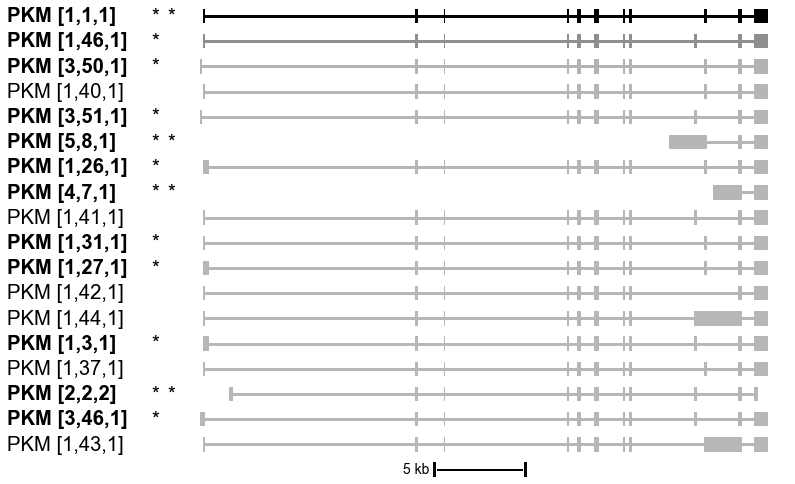

In [6]:
plot_browser_isos_2(cerberus_h5,
                    swan_file, 
                    filt_ab,
                    pp_summary,
                    major_isos,
                    ref_t_metadata,
                    ref_g_metadata,
                    'PKM',
                    obs_col,
                    'ovary',
                    'figures/pkm_ovary_browser_isos.pdf',
                    h=0.2,
                    ref_sources=['v29', 'v40'])

In [11]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_df = get_mp_orf_table(sg,
                ca,
                pp_summary,
                ref_t_metadata,
                ref_g_metadata,
                'dataset',
                min_tpm)    


Read in graph from ../data/human/swan_graph.p


In [12]:
mp_df.head()

,tid_princ,dataset,triplet_tpm_princ,triplet_pi_princ,gid,gname,triplet_rank_princ,tid_mane,triplet_tpm_mane,triplet_pi_mane,...,tid,seq,len,nmd,full_orf,tid_orf_mane,seq_orf_mane,len_orf_mane,nmd_orf_mane,full_orf_orf_mane
0,"ENSG00000285043[5,15,1]",wtc11_1_3,243.411350,95.34883,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",0.000000,0.357782,...,"ENSG00000285043[5,15,1]",YLKLGRGVALLTTHKCYRRSLALEYRVRRGASTTLRPRTLRYFRRS...,443.0,False,False,"ENSG00000285043[1,1,1]",MPYQYPALTPEQKKELSDIAHRIVAPGKGILAADESTGSIAKRLQS...,364.0,False,True
1,"ENSG00000285043[5,15,1]",wtc11_1_2,407.012120,96.36363,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",0.000000,0.227273,...,"ENSG00000285043[5,15,1]",YLKLGRGVALLTTHKCYRRSLALEYRVRRGASTTLRPRTLRYFRRS...,443.0,False,False,"ENSG00000285043[1,1,1]",MPYQYPALTPEQKKELSDIAHRIVAPGKGILAADESTGSIAKRLQS...,364.0,False,True
2,"ENSG00000285043[5,15,1]",wtc11_1_1,209.457550,95.86563,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",2.258303,1.033592,...,"ENSG00000285043[5,15,1]",YLKLGRGVALLTTHKCYRRSLALEYRVRRGASTTLRPRTLRYFRRS...,443.0,False,False,"ENSG00000285043[1,1,1]",MPYQYPALTPEQKKELSDIAHRIVAPGKGILAADESTGSIAKRLQS...,364.0,False,True
3,"ENSG00000285043[5,15,1]",upper_lobe_of_right_lung_1_1,60.622135,86.15385,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",2.165076,3.076923,...,"ENSG00000285043[5,15,1]",YLKLGRGVALLTTHKCYRRSLALEYRVRRGASTTLRPRTLRYFRRS...,443.0,False,False,"ENSG00000285043[1,1,1]",MPYQYPALTPEQKKELSDIAHRIVAPGKGILAADESTGSIAKRLQS...,364.0,False,True
4,"ENSG00000285043[5,15,1]",right_ventricle_myocardium_superior_1_1,540.761660,96.95652,ENSG00000285043,ENSG00000285043,1,NaN,0.000000,NaN,...,"ENSG00000285043[5,15,1]",YLKLGRGVALLTTHKCYRRSLALEYRVRRGASTTLRPRTLRYFRRS...,443.0,False,False,NaN,NaN,NaN,NaN,NaN


In [21]:
mp_df = mp_df.loc[mp_df.gname=='PKM']
mp_df = mp_df[['tid_mane', 'seq_orf_mane']].drop_duplicates()
mane_orf = mp_df.seq_orf_mane.values[0]
mane_orf

'MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTGIICTIGPASRSVETLKEMIKSGMNVARLNFSHGTHEYHAETIKNVRTATESFASDPILYRPVAVALDTKGPEIRTGLIKGSGTAEVELKKGATLKITLDNAYMEKCDENILWLDYKNICKVVEVGSKIYVDDGLISLQVKQKGADFLVTEVENGGSLGSKKGVNLPGAAVDLPAVSEKDIQDLKFGVEQDVDMVFASFIRKASDVHEVRKVLGEKGKNIKIISKIENHEGVRRFDEILEASDGIMVARGDLGIEIPAEKVFLAQKMMIGRCNRAGKPVICATQMLESMIKKPRPTRAEGSDVANAVLDGADCIMLSGETAKGDYPLEAVRMQHLIAREAEAAIYHLQLFEELRRLAPITSDPTEATAVGAVEASFKCCSGAIIVLTKSGRSAHQVARYRPRAPIIAVTRNPQTARQAHLYRGIFPVLCKDPVQEAWAEDVDLRVNFAMNVGKARGFFKKGDVVIVLTGWRPGSGFTNTMRVVPVP'

In [ ]:
plot_browser_isos_2(cerberus_h5,
                    swan_file, 
                    filt_ab,
                    major_isos,
                    'COL1A1',
                    obs_col,
                    'ovary',
                    'figures/col1a1_ovary_browser_isos.pdf',
                    h=0.2,
                    ref_sources=['v29', 'v40'])